1. Importação de Bibliotecas

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

2. Carregamento e Análise Exploratória

In [17]:
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')  

# Visualizar primeiras linhas
print("Primeiras linhas do dataset:")
print(df.head())

# Informações sobre o dataset
print("\nInformações do dataset:")
print(df.info())

# Estatísticas descritivas
print("\nEstatísticas descritivas:")
print(df.describe(include='all'))

Primeiras linhas do dataset:
   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         126/83          77         4200            NaN  
1    

3. Análise do Target e Balanceamento

    Criar variável target multiclasse (3 categorias)


Distribuição das classes:
Sleep_Quality
Medium    182
Good      180
Poor       12
Name: count, dtype: int64


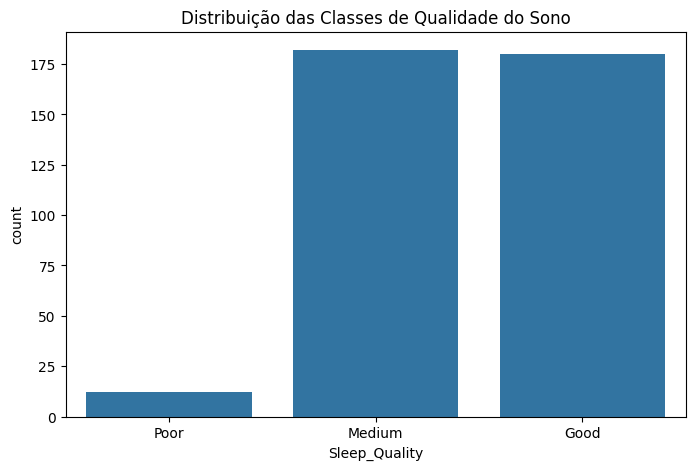

In [18]:
df['Sleep_Quality'] = pd.cut(df['Quality of Sleep'],
                            bins=[0, 5, 7, 10],
                            labels=['Poor', 'Medium', 'Good'])

print("\nDistribuição das classes:")
print(df['Sleep_Quality'].value_counts())

plt.figure(figsize=(8,5))
sns.countplot(x='Sleep_Quality', data=df, order=['Poor', 'Medium', 'Good'])
plt.title('Distribuição das Classes de Qualidade do Sono')
plt.show()


4. Visualizações das Features
    Relação entre features e target

<Figure size 1200x800 with 0 Axes>

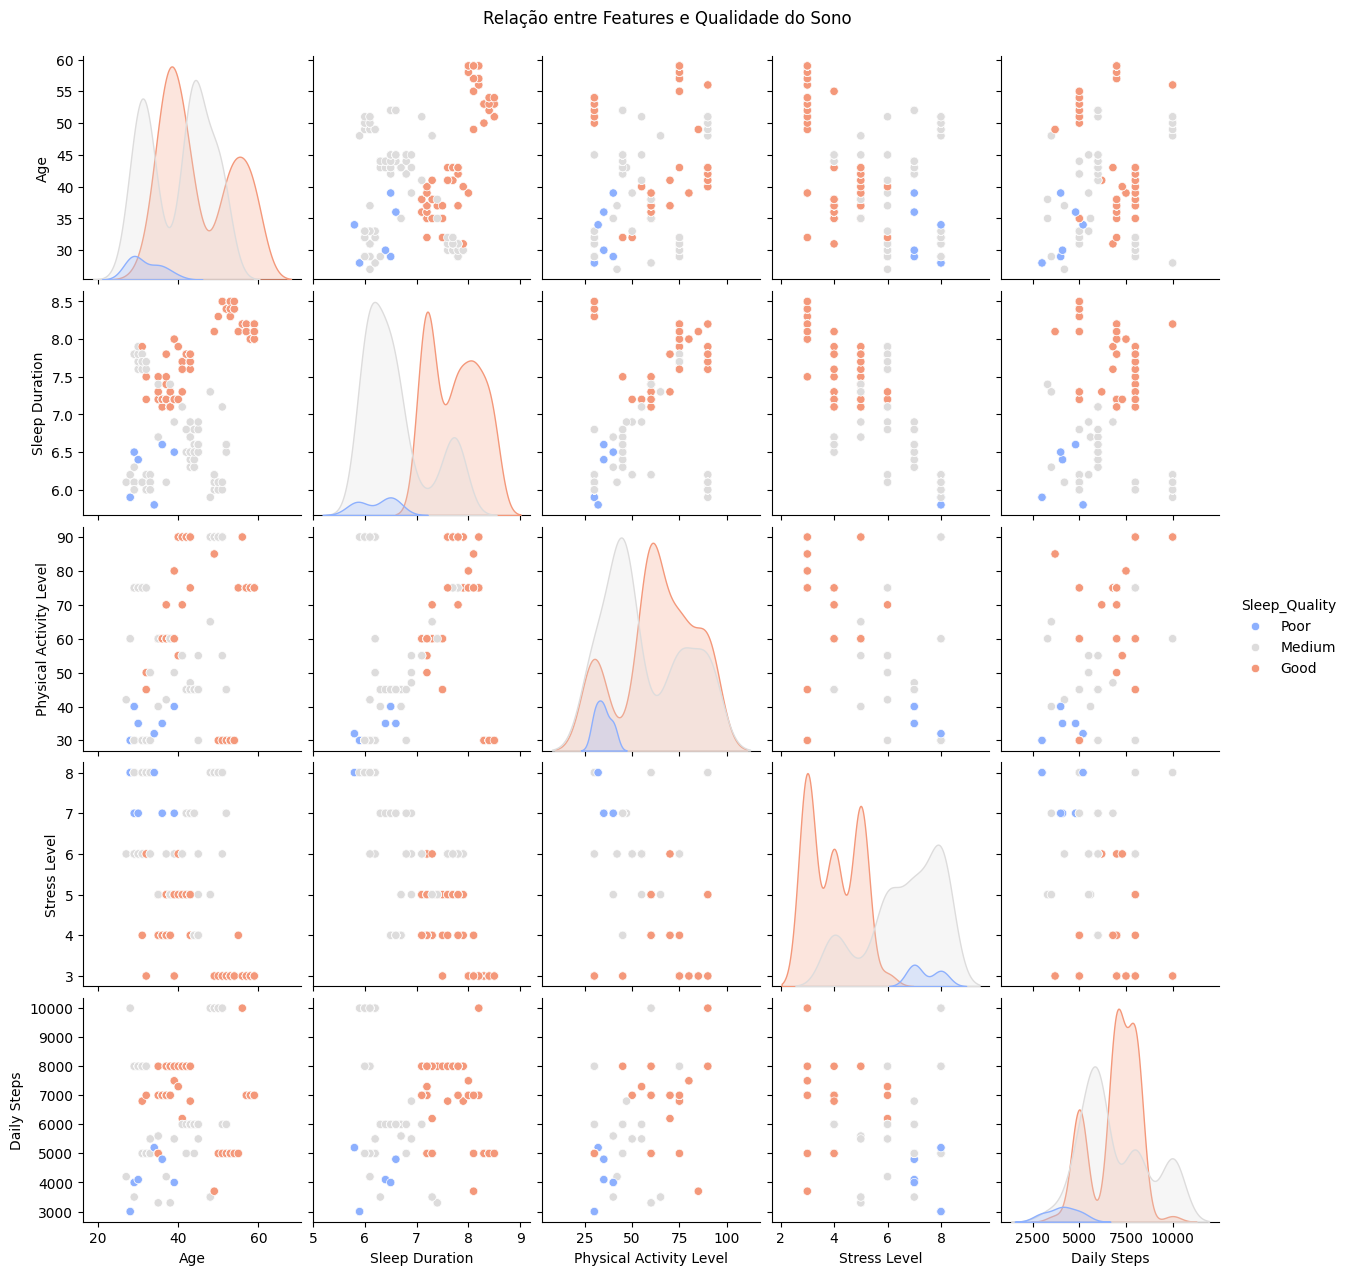

In [19]:
plt.figure(figsize=(12, 8))
sns.pairplot(df, vars=['Age', 'Sleep Duration', 'Physical Activity Level', 
                      'Stress Level', 'Daily Steps'], 
             hue='Sleep_Quality', palette='coolwarm')
plt.suptitle('Relação entre Features e Qualidade do Sono', y=1.02)
plt.show()

5. Correlação entre variáveis

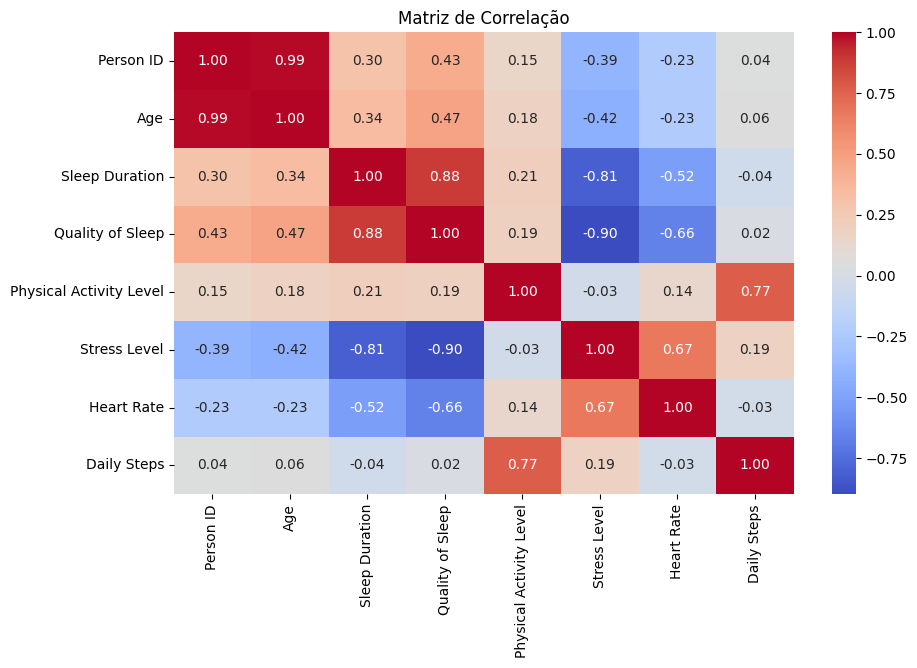

In [20]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

6. Pré-processamento dos Dados
    Selecionar features relevantes

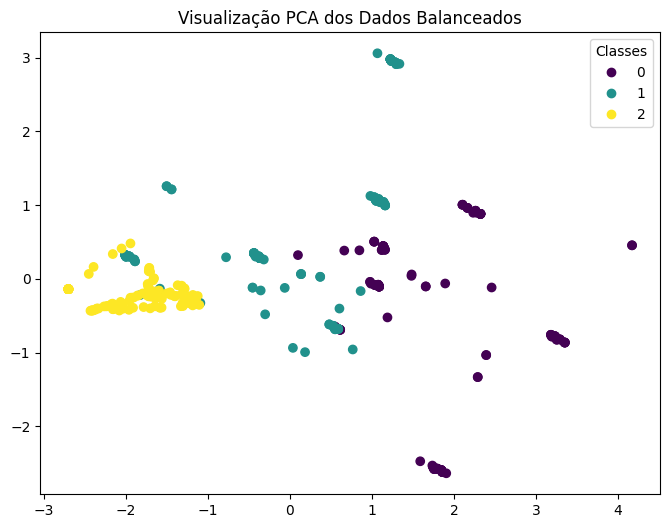

In [21]:
features = ['Age', 'Sleep Duration', 'Physical Activity Level', 
            'Stress Level', 'Daily Steps']

# Codificar target
le = LabelEncoder()
df['Sleep_Quality_Encoded'] = le.fit_transform(df['Sleep_Quality'])

# Separar features e target
X = df[features]
y = df['Sleep_Quality_Encoded']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Normalizar dados
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test = scaler.transform(X_test)

# Visualização PCA após balanceamento
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_bal)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_bal, cmap='viridis')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.title('Visualização PCA dos Dados Balanceados')
plt.show()


7. Treinamento e Avaliação de Modelos

In [22]:
# Função para avaliação completa
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Treinamento
    model.fit(X_train, y_train)
    
    # Predições
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Métricas
    print(f"\n=== {model_name} ===")
    print(f"Acurácia (Treino): {accuracy_score(y_train, y_pred_train):.2f}")
    print(f"Acurácia (Teste): {accuracy_score(y_test, y_pred):.2f}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Matriz de confusão
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()
    
    # Importância das features
    if hasattr(model, 'feature_importances_'):
        print("\nImportância das Features:")
        feat_imp = pd.Series(model.feature_importances_, index=features)
        print(feat_imp.sort_values(ascending=False))
        
        plt.figure(figsize=(8,4))
        feat_imp.sort_values().plot(kind='barh')
        plt.title(f'Importância das Features - {model_name}')
        plt.show()
    
    # Validação cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
    print(f"\nValidação Cruzada (5 folds): {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")


Árvore de Decisão


=== Árvore de Decisão ===
Acurácia (Treino): 0.99
Acurácia (Teste): 0.99

Relatório de Classificação:
              precision    recall  f1-score   support

        Good       1.00      0.98      0.99        54
      Medium       0.98      1.00      0.99        55
        Poor       1.00      1.00      1.00         4

    accuracy                           0.99       113
   macro avg       0.99      0.99      0.99       113
weighted avg       0.99      0.99      0.99       113



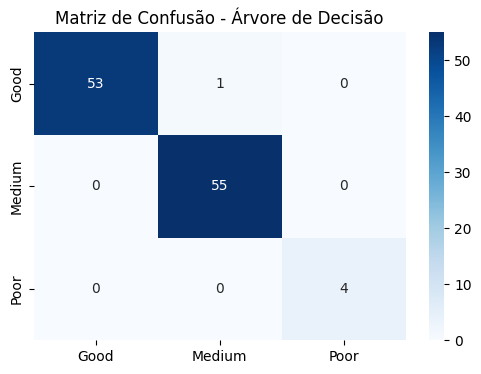


Importância das Features:
Daily Steps                0.442164
Stress Level               0.332548
Sleep Duration             0.171161
Physical Activity Level    0.042635
Age                        0.011493
dtype: float64


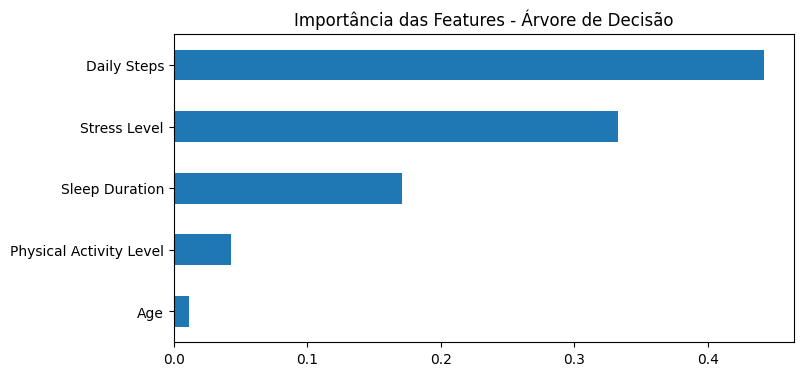


Validação Cruzada (5 folds): 0.98 ± 0.02


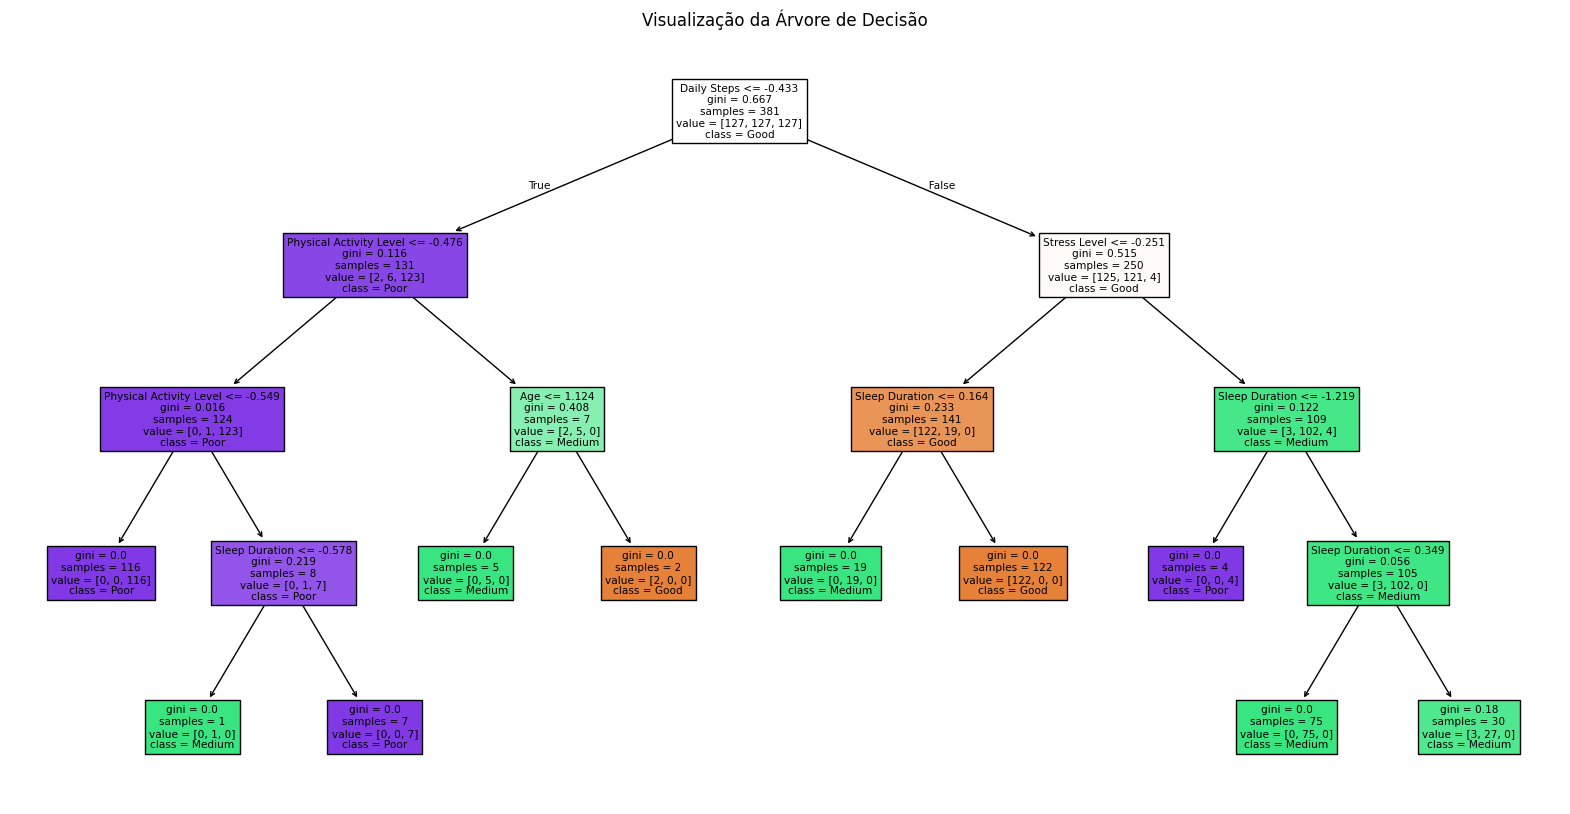

In [23]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_split=5, random_state=42)
evaluate_model(dt, X_train_bal, X_test, y_train_bal, y_test, "Árvore de Decisão")

# Visualização da árvore
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=features, class_names=le.classes_, filled=True)
plt.title('Visualização da Árvore de Decisão')
plt.show()


Random Forest


=== Random Forest ===
Acurácia (Treino): 1.00
Acurácia (Teste): 1.00

Relatório de Classificação:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00        54
      Medium       1.00      1.00      1.00        55
        Poor       1.00      1.00      1.00         4

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



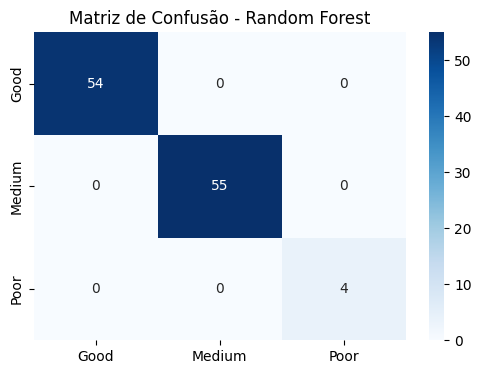


Importância das Features:
Daily Steps                0.339650
Stress Level               0.269444
Sleep Duration             0.217263
Physical Activity Level    0.103232
Age                        0.070411
dtype: float64


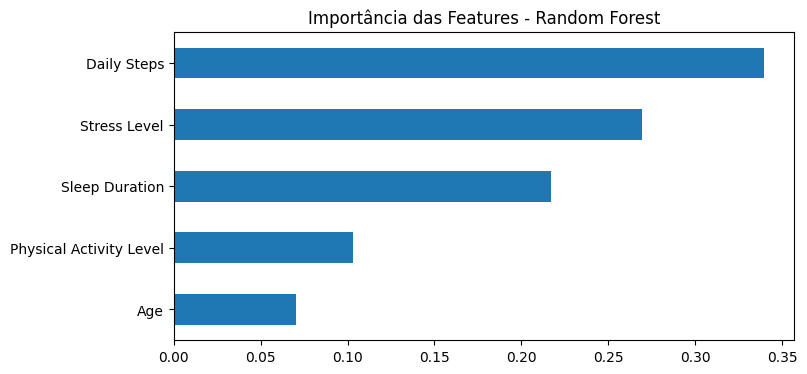


Validação Cruzada (5 folds): 0.99 ± 0.01


In [24]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
evaluate_model(rf, X_train_bal, X_test, y_train_bal, y_test, "Random Forest")

8. Fronteiras de Decisão (2 features principais)

<Figure size 1000x600 with 0 Axes>

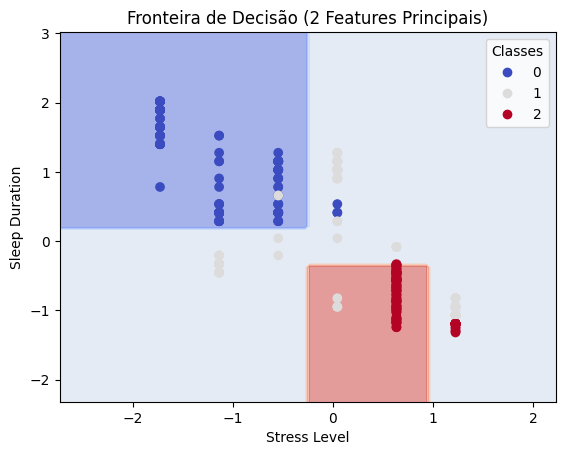

In [25]:
# Selecionar as 2 features mais importantes
top_features = ['Stress Level', 'Sleep Duration']

X_train_top = X_train_bal[:, [features.index(f) for f in top_features]]
X_test_top = X_test[:, [features.index(f) for f in top_features]]

# Treinar modelo simplificado
dt_simple = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_simple.fit(X_train_top, y_train_bal)

# Plotar fronteira de decisão
plt.figure(figsize=(10,6))
DecisionBoundaryDisplay.from_estimator(
    dt_simple, 
    X_train_top, 
    response_method="predict",
    cmap='coolwarm',
    alpha=0.5
)
scatter = plt.scatter(X_train_top[:, 0], X_train_top[:, 1], c=y_train_bal, cmap='coolwarm')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.title('Fronteira de Decisão (2 Features Principais)')
plt.show()


9. Análise Final


Comparação Final dos Modelos:
              Modelo  Acurácia Treino  Acurácia Teste
0  Árvore de Decisão         0.992126         0.99115
1      Random Forest         0.997375         1.00000


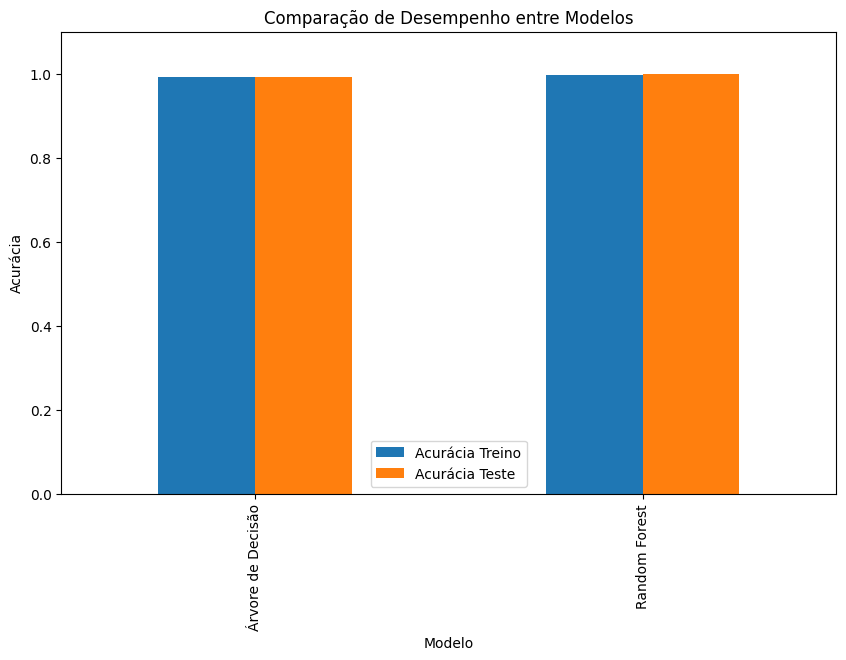

In [26]:
# Comparação final dos modelos
models = {
    'Árvore de Decisão': dt,
    'Random Forest': rf
}

results = []
for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    train_acc = accuracy_score(y_train_bal, model.predict(X_train_bal))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    results.append([name, train_acc, test_acc])

results_df = pd.DataFrame(results, columns=['Modelo', 'Acurácia Treino', 'Acurácia Teste'])
print("\nComparação Final dos Modelos:")
print(results_df)

# Plot
results_df.set_index('Modelo').plot(kind='bar', figsize=(10,6))
plt.title('Comparação de Desempenho entre Modelos')
plt.ylabel('Acurácia')
plt.ylim(0, 1.1)
plt.show()

Nível II

Avaliação com 30 execuções

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

def avaliar_modelo(modelo, X, y, n_execucoes=30):
    resultados = []
    for _ in range(n_execucoes):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        resultados.append(acc)
    return np.mean(resultados), np.std(resultados)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

modelo1 = RandomForestClassifier()
modelo2 = LogisticRegression(max_iter=1000)

media1, std1 = avaliar_modelo(modelo1, X, y)
media2, std2 = avaliar_modelo(modelo2, X, y)

print(f"RandomForest - Média: {media1:.4f}, Desvio Padrão: {std1:.4f}")
print(f"LogisticRegression - Média: {media2:.4f}, Desvio Padrão: {std2:.4f}")


RandomForest - Média: 0.9832, Desvio Padrão: 0.0134
LogisticRegression - Média: 0.9454, Desvio Padrão: 0.0318


Logo, RandomForest possui maior acurácia e menor desvio padrão

Salvando com Pickle

In [28]:
import pickle

# Treinando com todos os dados e salvar o melhor modelo
modelo_final = RandomForestClassifier()
modelo_final.fit(X, y)

# Salvando
with open("modelo_final.pkl", "wb") as f:
    pickle.dump(modelo_final, f)


Criando interface com Gradio

In [29]:
import gradio as gr

def prever(idade, genero, cafe, atividade, nivel_estresse, bpm, pressao, qualidade):
    entrada = pd.DataFrame([[idade, genero, cafe, atividade, nivel_estresse, bpm, pressao, qualidade]],
                           columns=X.columns)
    with open("modelo_final.pkl", "rb") as f:
        modelo = pickle.load(f)
    pred = modelo.predict(entrada)[0]
    return f"Predição de distúrbio do sono: {pred}"

interface = gr.Interface(
    fn=prever,
    inputs=[
        gr.Number(label="Idade"),
        gr.Number(label="Gênero (0=F, 1=M)"),
        gr.Number(label="Consumo de Café"),
        gr.Number(label="Atividade Física"),
        gr.Number(label="Nível de Estresse"),
        gr.Number(label="Frequência Cardíaca"),
        gr.Number(label="Pressão Sanguínea"),
        gr.Number(label="Qualidade do Sono")
    ],
    outputs="text",
    title="Classificador de Distúrbios do Sono"
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio\flagged\dataset1.csv
